<a href="https://colab.research.google.com/github/mlexchange/als_ml_tutorial/blob/main/2_2_ML_tutorial_dataLoading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# 2.4 Pytorch dataset and dataloader
In section 1.2, we learned how to load images and convert them to PyTorch Tensor Dataset. In this section, we will learn how to create training and validation Pytorch datasets that have `(data, label)` structure such that they can be used for supervised training. We will also learn to load these datasets in batches (avoid memory overflow) using a dataloader.

DataLoader has a few more advantages:
1. Shuffle data
2. Multiprocess loading

In [2]:
# download dataset
!wget -q 'https://drive.google.com/uc?id=1RTObsZOHLS4RUnwCegoxXD5EktvrSeI5' -O 'data_64x64_400.zip'
!unzip -q -n 'data_64x64_400.zip' && rm 'data_64x64_400.zip'

data_path = './data_64x64_400'

## 2.4.1 Create customized image dataset

We can create a customized dataset using `torch.utils.data.Dataset` which is an abstract class representing a dataset. In the example below, we are loading a dataset stored like this:  
```
data_64x64_400
  000001.jpg
  000002.jpg
  ...
```

In [3]:
# image processing
input_size = 64 # square image size
data_transform = transforms.Compose([transforms.Resize(input_size),
                                     transforms.CenterCrop(input_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5),
                                   ])

In [4]:
# create customized dataset class
class myDataset(torch.utils.data.Dataset):
    '''
    Args:
        folder      str, folder path
        format      str, formats supported by PIL
        label       int, default 0
        transform   callable, if not given return PIL image

    Return:
        tensor or PIL image     tuple, (image, label)
    '''
    def __init__(self, root=None, format=None, label=None, transform=None):
        _file_path = root+'/*.'+format if format else root+'/*'
        self.dataset = glob.glob(_file_path) #filenmae matching
        self.label = label if label else 0
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        if self.transform:
            return self.transform(Image.open(data)), self.label
        else:
            return Image.open(data), self.label


In [5]:
dataset = myDataset(root=data_path,
                    transform=data_transform)
print(next(iter(dataset)))

(tensor([[[ 0.2314,  0.2392,  0.2235,  ...,  0.2863,  0.3020,  0.3176],
         [ 0.2235,  0.2078,  0.2235,  ...,  0.2549,  0.2706,  0.2863],
         [ 0.1765,  0.2157,  0.2078,  ...,  0.2471,  0.2235,  0.2549],
         ...,
         [-0.3412, -0.3569, -0.3569,  ..., -0.2314, -0.2235, -0.2235],
         [-0.3412, -0.3569, -0.3647,  ..., -0.2235, -0.2235, -0.2314],
         [-0.3412, -0.3647, -0.3725,  ..., -0.2314, -0.2392, -0.2471]]]), 0)


## 2.4.2 Create datasets for training, validation, and testing

We can create these datasets separtely or we can use `torch.utils.data.random_split` to split the dataset.

In [6]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])
print(len(train_dataset), len(val_dataset), len(test_dataset))


240 80 80


## 2.4.3 Load data in batches

In [7]:
# Create the dataloader
batch_size = 16
workers = 0 # workers=0 for a local machine
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=workers,
                                               drop_last=False,
                                               prefetch_factor=None) # prefetch=None if workers=0

print(len(train_dataloader))
print(next(iter(train_dataloader)))

15
[tensor([[[[-0.7255, -0.7412, -0.7725,  ..., -0.7647, -0.7725, -0.7647],
          [-0.7412, -0.7412, -0.7255,  ..., -0.7333, -0.7333, -0.7490],
          [-0.7412, -0.7490, -0.7176,  ..., -0.7569, -0.7333, -0.7647],
          ...,
          [-0.8275, -0.8275, -0.8275,  ..., -0.8275, -0.8275, -0.8275],
          [-0.8275, -0.8196, -0.8196,  ..., -0.8275, -0.8353, -0.8353],
          [-0.8118, -0.8275, -0.8196,  ..., -0.8196, -0.8275, -0.8275]]],


        [[[ 0.0431,  0.0275,  0.0745,  ..., -0.0510, -0.0902, -0.0745],
          [ 0.0902,  0.1843,  0.2549,  ...,  0.0667, -0.0196, -0.1216],
          [ 0.2627,  0.2627,  0.2000,  ...,  0.1137,  0.1137,  0.0275],
          ...,
          [-0.7725, -0.7961, -0.8039,  ..., -0.8196, -0.8196, -0.8196],
          [-0.7412, -0.7882, -0.8039,  ..., -0.8196, -0.8118, -0.8196],
          [-0.7804, -0.7647, -0.7961,  ..., -0.8196, -0.8118, -0.8196]]],


        [[[ 0.0667,  0.0510,  0.0510,  ..., -0.3882, -0.3882, -0.4039],
          [ 0.0667,  0

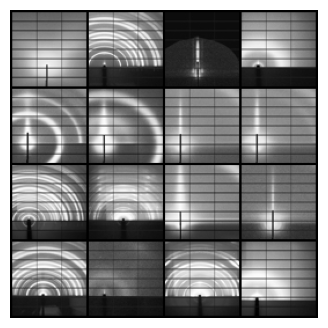

In [8]:
# plot batch images
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(next(iter(train_dataloader))[0], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

## Bonus: create image dataset from directory

If your dataset have subfolders representing different classes, we can use `torchvision.datasets.ImageFolder` to  create an image dataset from directory.

In the example below, we are loading a dataset stored like this:  
```
data
  class1
    000001.jpg
    000002.jpg
    ...
  class2
    000201.jpg
    000202.jpg
  ...
```

In [10]:
# make a new dataset
import os, shutil

src = './data_64x64_400/'
dsts = ['./data/class1/', './data/class2/']
for dst in dsts:
  if not os.path.exists(dst):
    os.makedirs(dst)

for i in range(1, 201):
  fn = str(i).zfill(6)+'.jpg'
  shutil.copyfile(src+fn, dsts[0]+fn)

for i in range(201, 401):
  fn = str(i).zfill(6)+'.jpg'
  shutil.copyfile(src+fn, dsts[1]+fn)


In [11]:
# Create the dataset
dataset = torchvision.datasets.ImageFolder(root='data',
                                           transform=data_transform)

# each subdir is labeled as 0,1,...
print(len(dataset))
print(next(iter(dataset)))  # get the first image and its label

# for data, label in dataset:
#   print(label, data)

400
(tensor([[[-0.5608, -0.5608, -0.5529,  ..., -0.5843, -0.5922, -0.5922],
         [-0.5529, -0.5529, -0.5451,  ..., -0.5843, -0.5843, -0.6000],
         [-0.5529, -0.5373, -0.5294,  ..., -0.5843, -0.5843, -0.5843],
         ...,
         [-0.0431,  0.0588,  0.0980,  ..., -0.3961, -0.3961, -0.3961],
         [-0.0824,  0.0039,  0.0667,  ..., -0.3961, -0.3961, -0.3961],
         [-0.1059, -0.0667,  0.0353,  ..., -0.3961, -0.3961, -0.3961]],

        [[-0.5608, -0.5608, -0.5529,  ..., -0.5843, -0.5922, -0.5922],
         [-0.5529, -0.5529, -0.5451,  ..., -0.5843, -0.5843, -0.6000],
         [-0.5529, -0.5373, -0.5294,  ..., -0.5843, -0.5843, -0.5843],
         ...,
         [-0.0431,  0.0588,  0.0980,  ..., -0.3961, -0.3961, -0.3961],
         [-0.0824,  0.0039,  0.0667,  ..., -0.3961, -0.3961, -0.3961],
         [-0.1059, -0.0667,  0.0353,  ..., -0.3961, -0.3961, -0.3961]],

        [[-0.5608, -0.5608, -0.5529,  ..., -0.5843, -0.5922, -0.5922],
         [-0.5529, -0.5529, -0.5451,  ..